## Transformacja współrzędnych elipsoidalnych samolotu na kartezjańskie

Autor: **Radosław Dąbkowski**

Numer indeksu: **325683**

## Treść zadania

Celem ćwiczenia jest przekształcenie współrzędnych elipsoidalnych lecącego samolotu do układu lokalnego. Dane do zadania zawierają współrzędne geodezyjne (szerokość φ, długość λ, i wysokość h) samolotu w odstępach czasu. Współrzędne te należy przeliczyć na współrzędne ortokartezjańskie, a następnie na współrzędne horyzontalne względem znanego lotniska. Dodatkowo, należalo określić moment, w którym samolot znika poniżej horyzontu.

Dane do zadania:
* dane o locie samolotu z portalu [Flightradar24](https://www.flightradar24.com) w pliku `lot2.csv`

Wykonane wizualizacje to:
* trajektoria lotu na mapie wraz z kolorem oznaczającym to, czy samolot jest powyżej czy poniżej horyzontu względem Warszawy,
* wykres zależności prędkości samolotu od czasu


In [56]:
# -*- coding: utf-8 -*-
"""
Created on Mon Oct 17 12:38:20 2022

@author: mgrzy
"""

import numpy as np

def read_flightradar(file) -> np.array:
    '''
    Parameters
    ----------
    file : .csv file - format as downloaded from fligthradar24
        DESCRIPTION.
    Returns
    -------
    all_data : numpy array
        columns are:
            0 - Timestamp - ?
            1 - year
            2 - month
            3 - day
            4 - hour
            5 - minute
            6 - second
            7 - Latitude [degrees]
            8 - Longitude [degrees]
            9 - Altitude [feet]
            10 - Speed [?]
            11 - Direction [?]
    '''
    with open(file, 'r') as f:
        i = 0
        size= []
        Timestamp = []; date = []; UTC = []; Latitude = []; Longitude = []; 
        Altitude = []; Speed = []; Direction = []; datetime_date = []
        for linia in f:
            if linia[0:1]!='T':
                splited_line = linia.split(',')
                size.append(len(splited_line))
                i+=1
                Timestamp.append(int(splited_line[0]))
                full_date = splited_line[1].split('T')
                date.append(list(map(int,full_date[0].split('-'))))
                UTC.append(list(map(int, full_date[1].split('Z')[0].split(':'))))
                Callsign = splited_line[2]
                Latitude.append(float(splited_line[3].split('"')[1]))
                Longitude.append(float(splited_line[4].split('"')[0]))
                Altitude.append(float(splited_line[5]))
                Speed.append(float(splited_line[6]))
                Direction.append(float(splited_line[7]))
                
    all_data = np.column_stack((np.array(Timestamp), np.array(date), np.array(UTC),
                                np.array(Latitude), np.array(Longitude), np.array(Altitude),
                                np.array(Speed), np.array(Direction)))
    return all_data

def blh2xyz(fi, lam, h) -> np.array:
    '''
    Parameters
    ----------
    fi : float
        latitude [rad].
    lam : float
        longitude [rad].
    h : float
        height [m].
    Returns
    -------
    xyz : numpy array
        x, y, z [m].
    '''
    a = 6378137.0
    e2 = 0.00669438002290
    N = a/np.sqrt(1-e2*np.sin(fi)**2)
    x = (N+h)*np.cos(fi)*np.cos(lam)
    y = (N+h)*np.cos(fi)*np.sin(lam)
    z = (N*(1-e2)+h)*np.sin(fi)
    xyz = np.array([x, y, z])
    return xyz

def Rneu(phi, lamb) -> np.array:
    '''
    Parameters
    ----------
    phi : float
        latitude [rad].
    lamb : float
        longitude [rad].
    Returns
    -------
    R : numpy array
        rotation matrix.
    '''
    R = np.array([[-np.sin(phi)*np.cos(lamb), -np.sin(lamb), -np.cos(phi)*np.cos(lamb)],
                    [-np.sin(phi)*np.sin(lamb), np.cos(lamb), -np.cos(phi)*np.sin(lamb)],
                    [np.cos(phi), 0, -np.sin(phi)]])
    return R

### Opis rozwiązania

1. Przeliczenie współrzędnych φ, λ, h na współrzędne ortokartezjańskie XYZ

    Obliczenie promienia przekroju Ziemi w kierunku I Wertykału (N) używając wzoru:
    
        N = a * sqrt(1 - e2 * sin2(φ))

    Gdzie:
    
        a = 6,378,137 m
        e2 = 0,006 694 380 022 90

    Obliczenie współrzędnych X, Y, Z używając wzorów:
    
        X = (N + h) * cos(φ) * cos(λ)
        Y = (N + h) * cos(φ) * sin(λ)
        Z = [N * (1 - e2) + h] * sin(φ)

2. Obliczenie wektora samolot - lotnisko Xs

    Obliczenie wektora różnicy między współrzędnymi XYZ samolotu (Xs) i lotniska (Xl).

3. Transformacja współrzędnych wektora Xs do układu współrzędnych lokalnych

    Zdefiniowanie wektora normalnego do elipsoidy w danym punkcie (u) używając wzoru:

        u = [cos(φ) * cos(λ), cos(φ) * sin(λ), sin(φ)]

    Obliczenie osi n i e używając wzorów:

        n = [-sin(φ) * cos(λ), -sin(φ) * sin(λ), cos(φ)]
        e = [1, 0, 0]
        
    Skomponowanie macierzy obrotu między układem współrzędnych geocentrycznych a lokalnymi (Rneu) używając obliczonych osi n i e.
    Przekształcenie wektora Xs do układu lokalnego używając macierzy obrotu Rneu.

4. Wykonanie wizualizacji
    
    Wizualizację trasy przelotu wykonano w bibliotece folium. Kolorem niebieskim oznaczono odcinek trasy, w którym samolot znajdował się powyżej horyzontu, a kolorem czerwonym oznaczono odcinek trasy, w którym samolot znajdował się poniżej horyzontu.

In [57]:
import matplotlib.pyplot as plt
import folium
import os

m = folium.Map(location=[52.1657, 20.9671], zoom_start=5)

# for lot in the folder loty
dane = read_flightradar(f"lot2.csv")
# delete unchanging height
dane = np.delete(dane, np.where(dane[:,9]==dane[0,9]), axis=0)
flh = dane[:,[7,8,9]]
flh[:,1] = flh[:,1]*0.3048 + 135.4

flh_lotnisko = flh[0,:]
flh = np.delete(flh, np.where(flh[:,2]==flh_lotnisko[2]), axis=0)
xyz_lotnisko = blh2xyz(np.deg2rad(flh_lotnisko[0]), np.deg2rad(flh_lotnisko[1]), flh_lotnisko[2])

R = Rneu(np.deg2rad(flh_lotnisko[0]), np.deg2rad(flh_lotnisko[1]))

last_coords = [dane[0,7], dane[0,8]]
velocities = []
azimuths = []
odleglosci = []

for i, (fi, lam, h) in enumerate(flh):
    xyz = blh2xyz(np.deg2rad(fi), np.deg2rad(lam), h)
    xsl = xyz - xyz_lotnisko
    neu = R.T.dot(xsl)
    Az = np.rad2deg(np.arctan2(neu[1],neu[0]))
    azimuths.append(Az)
    s = np.sqrt(neu[0]**2 + neu[1]**2 + neu[2]**2) / 1000
    odleglosci.append(s)
    z = 90 - np.rad2deg(np.arcsin(neu[2]/s))

    lat = dane[i,7]
    lon = dane[i,8]

    # calculate plane visibility on the horizon
    if neu[2] < 0:
        color = 'green'
    else:
        color = 'red'

    folium.PolyLine(locations=[[last_coords[0], last_coords[1]], [lat, lon]], color=color).add_to(m)
    last_coords = [lat, lon]

    # calculate velocity
    v = dane[i,10]
    velocities.append(v)

m

/tmp/ipykernel_1522/994151169.py:33: RuntimeWarning: invalid value encountered in arcsin
  z = 90 - np.rad2deg(np.arcsin(neu[2]/s))


Wykres prędkości samolotu

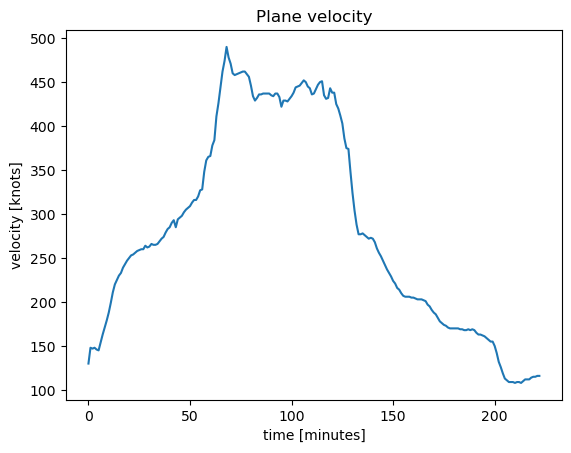

In [58]:
# create a velocity plot
plt.plot(velocities)
plt.xlabel('time [minutes]')
# w wezlach
plt.ylabel('velocity [knots]')
plt.title('Plane velocity')
plt.show()

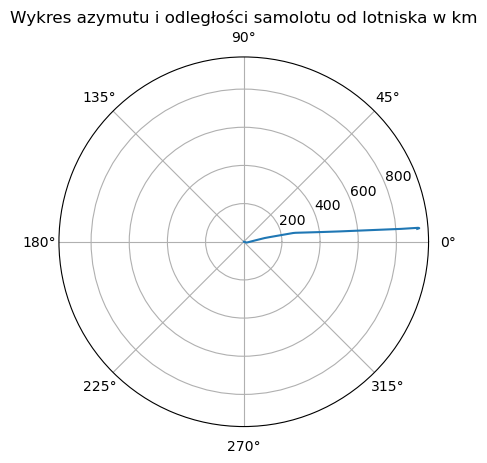

In [59]:
# polar azimuth distance plot
plt.polar(np.deg2rad(azimuths), odleglosci)
plt.title('Wykres azymutu i odległości samolotu od lotniska w km')
plt.show()